In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from xgboost import XGBRegressor
train_b = True
model_name = 'model_slope_with_solar_weather_XGBRegressor_HWC_10.json'

In [27]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))    
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [28]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [29]:
data =  pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv")
df_t = pd.to_datetime(data['Time Stamp'])

future_var = ['Dni','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','Dni Future','HourlyDryBulbTemperature Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

N.Y.C. 630990 5785.991561071094 1225.7784954986557
Dni 630990 176.76888857192665 310.5093273356992
HourlyDryBulbTemperature 630990 55.41817575836172 16.948338021415687
Dni Future 630990 176.76888857192665 310.5093273356991
HourlyDryBulbTemperature Future 630990 55.41831082066088 16.948266591608352
   N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future
0  5116.9  0.0                      44.0         0.0                        44.588235
1  5102.1  0.0                      44.0         0.0                        44.686275
2  5074.9  0.0                      44.0         0.0                        44.784314
3  5089.6  0.0                      44.0         0.0                        44.882353
4  5061.3  0.0                      44.0         0.0                        44.980392


In [30]:
import datetime
import holidays
def get_national_holidays(start_date, end_date, country):
    # Get the Bank Holidays for the given country
    holiday_days = holidays.CountryHoliday(country)
    # Create a list of dates between the start and end date
    date_range = pd.date_range(start_date, end_date)
    # Filter the dates to only include Bank Holidays
    national_holidays = [str(date)[0:10] for date in date_range if date in holiday_days]
    return national_holidays

#Holiday Boolean
holidays = get_national_holidays(df_t.min(), df_t.max(), 'US')
data['Holiday_Weekend_B'] = df_t.astype(str).str[0:10].isin(holidays).map({True:1, False:0})
#Weekend Boolean (Weekends are 5&6)
data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
data['Holiday_Weekend_B']=data['Holiday_Weekend_B'].shift(forecast_window).bfill().ffill()

#Covid Boolean
ts = datetime.datetime(2020,3,17,0,0,0)
te = datetime.datetime(2021,9,7,0,0,0)
data['Covid_B']=0
data['Covid_B'][(df_t>=ts) & (df_t<=te)]=1
data['Covid_B']=data['Covid_B'].shift(forecast_window).bfill().ffill()

#Print
print(data.head(20).to_string())
used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','Dni Future','HourlyDryBulbTemperature Future','Holiday_Weekend_B','Covid_B']

    N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future  Holiday_Weekend_B  Covid_B
0   5116.9  0.0                 44.000000         0.0                        44.588235                1.0      0.0
1   5102.1  0.0                 44.000000         0.0                        44.686275                1.0      0.0
2   5074.9  0.0                 44.000000         0.0                        44.784314                1.0      0.0
3   5089.6  0.0                 44.000000         0.0                        44.882353                1.0      0.0
4   5061.3  0.0                 44.000000         0.0                        44.980392                1.0      0.0
5   5042.6  0.0                 44.000000         0.0                        44.933333                1.0      0.0
6   5011.6  0.0                 44.000000         0.0                        44.850000                1.0      0.0
7   4999.3  0.0                 44.000000         0.0                        44.

<ipython-input-30-8796d6b9ff7a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
<ipython-input-30-8796d6b9ff7a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Covid_B'][(df_t>=ts) & (df_t<=te)]=1


In [31]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 176.74872041098973 ;std_s = 310.4973536354869
m_t = 56.030910041113;std_t = 16.507268780702415
m_d = 0;std_d=1
#N.Y.C. 631062 5785.801098166661 1225.8381262919374
#Dni 631062 176.74872041098973 310.4973536354869
#HourlyDryBulbTemperature 631062 55.41743325211331 16.947708813988072

m_list = [m,m_s,m_t,m_s,m_t,m_d,m_d]
std_list = [std,std_s,std_t,std_s,std_t,std_d,std_d]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    a=a.flatten()
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [32]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

In [33]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
def create_XGBRegressor_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = XGBRegressor(objective='reg:squarederror', n_estimators=10)
    #model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

model = create_XGBRegressor_model(LSTM_i=100, var_num=num_var)
#model.summary()
#plot_model(model, show_shapes=True, dpi=90)

In [34]:
#Fit Model

print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t,verbose=True) 
  model.save_model(f"{MODEL_DIR}/{model_name}")
else: 
  model.load_model(f"{MODEL_DIR}/{model_name}") 
print(datetime.datetime.now())

2023-03-12 20:27:30.222332
2023-03-12 20:43:02.063931


Total Test Score: 400.41 RMSE
90 Min Test Score: 144.53 RMSE
Relative Test Score: 2.49 perc RMSE


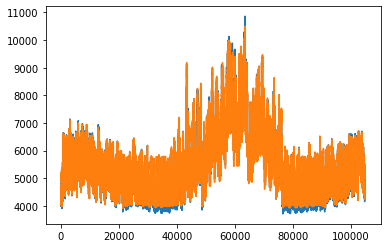

In [35]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

# Example

In [36]:
'''
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()
'''

"\n# forecast monthly births with xgboost\nfrom numpy import asarray\nfrom pandas import read_csv\nfrom pandas import DataFrame\nfrom pandas import concat\nfrom sklearn.metrics import mean_absolute_error\nfrom xgboost import XGBRegressor\nfrom matplotlib import pyplot\n\n# transform a time series dataset into a supervised learning dataset\ndef series_to_supervised(data, n_in=1, n_out=1, dropnan=True):\n\tn_vars = 1 if type(data) is list else data.shape[1]\n\tdf = DataFrame(data)\n\tcols = list()\n\t# input sequence (t-n, ... t-1)\n\tfor i in range(n_in, 0, -1):\n\t\tcols.append(df.shift(i))\n\t# forecast sequence (t, t+1, ... t+n)\n\tfor i in range(0, n_out):\n\t\tcols.append(df.shift(-i))\n\t# put it all together\n\tagg = concat(cols, axis=1)\n\t# drop rows with NaN values\n\tif dropnan:\n\t\tagg.dropna(inplace=True)\n\treturn agg.values\n\n# split a univariate dataset into train/test sets\ndef train_test_split(data, n_test):\n\treturn data[:-n_test, :], data[-n_test:, :]\n\n# fit an 